# Computer Vision Exercise 5 - Variational AutoEncoder
In this exercise, we are going to implement a type of generative model called **Variational AutoEncoder (VAE)** and its variant called **Conditional Variational AutoEncoder (CVAE)** that can generate the output conditioned on additional signals such as class labels.

We will use the MNIST dataset which is a collection of hand-written images of 10 digits.

**Your task**: Fill in the missing code according to the assignment descriptiond.

**Note**: You should run this notebook with GPU. Using Google Colab is encouraged for people without CUDA-enable machine. The training with GPU should take  take around 5 - 10 minutes.

In [50]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [51]:
# Prepare the MNIST dataset
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the test data
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [52]:
# Check data size
print(train_dataset.data.shape)  # [N, height, width]
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


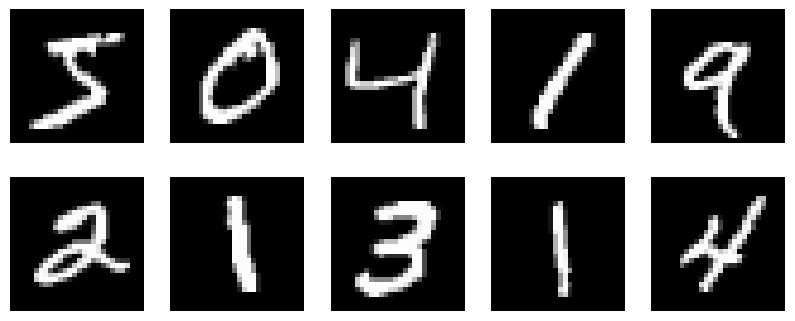

In [53]:
# Display 10 images from the MNIST dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_dataset.data[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

### VAE model (50 points)
In standard VAE implementation, the model consists of an **encoder** that encodes the training image into a latent vector and a **decoder** that transforms the latent vector into output an image. As the goal of VAE is to produce a distribution that we can sample from, the output of the encoder is not any latent vector but is a mean and a variance of a Gaussian distribution (which we will implement in log space for numerical stability).

Your model must meet the following specifications:

*   **Encoder** - consists of 1 input layer, 1(or more) hidden layer, and 2 branches of output layer that produce **the mean and log variance** in the latent space.
*   **Decoder** - consists of 1 input layer, 0(or more) and 1 output layer.
* All layers are normal feed-forward layers (sometimes called MLP).
* We will use ReLu activations for all layers except for the output of the decoder, which we will use the Sigmoid function to ensure that the output is in the [0,1] range.
* You can change the hyperparameters and number of layers to improve the results (but not the model structure). The given hyperparameters should provide a good starting point without much computational cost.



In [54]:
# Define model hyperparameters. ## You can change these to improve the results ##
input_dim = 784  # 28 x 28
hidden_dim = 256
latent_dim = 32

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        ####### TODO: define model layers (5 pts) #######
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(4 * 4 * 128, 2)  # Latent dimension = 2
        self.fc_log_var = nn.Linear(4 * 4 * 128, 2)
        
        ##### END TODO: define model layers #####

    def forward(self, x):
        ####### TODO: implement encoder forward pass (5 pts) #######
        x = F.relu(self.conv1(x))
        # print("conv1", x.shape)
        
        x = F.relu(self.conv2(x))
        # print("conv2", x.shape)
        x = F.relu(self.conv3(x))
        # print("conv3", x.shape)
        
        x = self.flatten(x)
        # print("flatten", x.shape)   
        mu = self.fc_mean(x)
        logvar = self.fc_log_var(x)
        
        ##### END TODO: implement encoder forward pass #####
        # The encoder returns the mean and the log-variance of the latent space
        return mu, logvar

In [56]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        ####### TODO: define model layers (5 pts) #######
        self.fc = nn.Linear(2, 7 * 7 * 128)  # Matches the encoder output
        self.conv_transpose1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)  # Adjusted stride and padding

        ##### END TODO: define model layers #####

    def forward(self, z):
        ####### TODO: implement decoder forward pass (5 pts) #######
        # Compute the output z. The value in z should be in range [0,1] and
        # must be reshape back to (batch_size, 1, 28, 28) or
        # (batch_size, 28, 28) depending on your implementation.
        z = self.fc(z)
        z = z.view(-1, 128, 7, 7)  # Reshape to (batch_size, channels, height, width)
        z = torch.relu(self.conv_transpose1(z))
        z = torch.relu(self.conv_transpose2(z))
        z = torch.sigmoid(self.conv_transpose3(z)) 
        ##### END TODO: implement decoder forward pass #####
        return z

In [57]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, output_dim)

    def reparameterize(self, mu, logvar):
        ####### TODO: implement the reparameterization trick (5 pts) #######


        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    ##### END TODO: implement the reparameterization trick #####

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [58]:
# Define model
model_vae = VAE(input_dim, hidden_dim, latent_dim, input_dim)

In [59]:
def vae_loss(x_recon, x, mu, logvar):
    ####### TODO: implement VAE loss (5 pts) #######
    # The VAE loss consists of two parts: the reconstruction loss between
    # the input and output and the KL-divergence loss that tries to encourage the
    # learned space to be clase to N(0,1).

    reconstruction_loss = nn.functional.binary_cross_entropy_with_logits(x_recon, x, reduction='sum')
    
    # KL divergence loss
    kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reconstruction_loss + kl_divergence_loss
    ##### END TODO: implement VAE loss #####

In [60]:
####### TODO: define an optimizer (5 pts combined with training) #######
# You can use any optimizer you prefer
optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-3)
##### END TODO: define an optimizer #####

In [61]:
import torch
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vae = model_vae.to(device)

####### TODO: implement the training loop of the model #######
# Use the prepared MNIST dataset. You should print the loss every epoch or
# every few hundred steps to see the training progression
epochs = 5  # You can adjust the training epoch to improve performance.
for epoch in range(epochs):
    model_vae.train()
    train_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model_vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i % 100 == 0:
            print(f'Epoch {epoch}, Step {i}, Loss {loss.item()}')

    print(f'Epoch {epoch}, Average Loss: {train_loss / len(train_loader.dataset)}')


conv1 torch.Size([64, 32, 14, 14])
conv2 torch.Size([64, 64, 7, 7])
conv3 torch.Size([64, 128, 4, 4])
flatten torch.Size([64, 2048])
Epoch 0, Step 0, Loss 44942.52734375
conv1 torch.Size([64, 32, 14, 14])
conv2 torch.Size([64, 64, 7, 7])
conv3 torch.Size([64, 128, 4, 4])
flatten torch.Size([64, 2048])
conv1 torch.Size([64, 32, 14, 14])
conv2 torch.Size([64, 64, 7, 7])
conv3 torch.Size([64, 128, 4, 4])
flatten torch.Size([64, 2048])
conv1 torch.Size([64, 32, 14, 14])
conv2 torch.Size([64, 64, 7, 7])
conv3 torch.Size([64, 128, 4, 4])
flatten torch.Size([64, 2048])
conv1 torch.Size([64, 32, 14, 14])
conv2 torch.Size([64, 64, 7, 7])
conv3 torch.Size([64, 128, 4, 4])
flatten torch.Size([64, 2048])
conv1 torch.Size([64, 32, 14, 14])
conv2 torch.Size([64, 64, 7, 7])
conv3 torch.Size([64, 128, 4, 4])
flatten torch.Size([64, 2048])
conv1 torch.Size([64, 32, 14, 14])
conv2 torch.Size([64, 64, 7, 7])
conv3 torch.Size([64, 128, 4, 4])
flatten torch.Size([64, 2048])
conv1 torch.Size([64, 32, 14, 14

KeyboardInterrupt: 

### Test VAE reconstruction results (5 points) ###
Here, we want to check if the model can do normal reconstruction (no sampling) given input images.
The output images should hopefully be very close to the input images.

Note: **You will receive no points if the reconstructed image is not any similar to the input image.** Acceptable results look similar to this example (top row: test images, bottom row: reconstructed images)

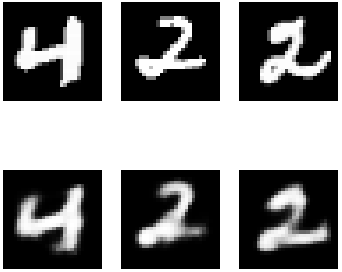

In [ ]:
# Reconstruct and visualize some test images
with torch.no_grad():
    for i, (x, _) in enumerate(test_loader):
        x = x.to(device)
        x_recon, _, _ = model_vae(x)
        break  # Only process one batch for visualization

# Display original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_recon[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.show()

conv1 torch.Size([1000, 32, 14, 14])
conv2 torch.Size([1000, 64, 7, 7])
conv3 torch.Size([1000, 128, 4, 4])
flatten torch.Size([1000, 2048])


UnboundLocalError: local variable 'x' referenced before assignment

### Visualize VAE sampling results (10 points)
**Note**: You will receive no points if less than or equal to 3 images is clealy recognizable as a digit.

In [ ]:
####### TODO: sample 10 images from the model #######
# Sample from Gaussian noise
num_samples = 10
pass

# Generate images from the noise
pass

# The output images must be in the generated_images variable.
# generated_images = ...
##### END TODO sample 10 images from the model #######

In [ ]:
# Visualize the generated images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

# **Conditional Variational AutoEncoder (CVAE)**
(50 points)
CVAE is a type of VAE that also takes an additional condition vector as input such that the generation can be controlled e.g. generating images of digit 3. This vector is generally given as input to both the encoder and decoder model.

In this exercise, we will use a **one-hot encoding** (by calling `F.one_hot()`) to transform the given class label to a vector of size 10, which is then concatenated to both the encoder and decoder input. All other model structures are the same as the VAE above.

In [ ]:
class ConditionalEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(ConditionalEncoder, self).__init__()
        ####### TODO: define model layers (5 pts) #######
        # Do not forget to account for the size of the one-hot class vector as well

        ####### END TODO define model layers #######

    def forward(self, x, c):
        ####### TODO: forward pass (5 pts) #######
        # Do not forget to concatenate the image and class label

        ####### END TODO forward pass #######
        return mu, logvar

class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_classes):
        super(ConditionalDecoder, self).__init__()
        ####### TODO: define model layers (5 pts) #######

        ####### END TODO define model layers #######

    def forward(self, z, c):
        ####### TODO: implement decoder forward pass (5 pts) #######
        # Compute the output z. The value in z should be in range [0,1] and
        # must be reshape back to (batch_size, 1, 28, 28) or
        # (batch_size, 28, 28) depending on your implementation.
        # Concatenate the latent vector and class label

        ####### END TODO implement decoder forward pass #######
        return z

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim, num_classes):
        super(ConditionalVAE, self).__init__()
        self.encoder = ConditionalEncoder(input_dim, hidden_dim, latent_dim, num_classes)
        self.decoder = ConditionalDecoder(latent_dim, hidden_dim, output_dim, num_classes)

    def reparameterize(self, mu, logvar):
        ####### TODO: implement the reparameterization trick (5 pts) #######

        return ...
        ##### END TODO: implement the reparameterization trick #####

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, c)
        return x_recon, mu, logvar

In [ ]:
# Define model hyperparameters. ## You can change these to improve the results ##
input_dim = 784  # 28 x 28
hidden_dim = 256
latent_dim = 32

In [ ]:
# Define model
num_classes = 10 # MNIST has 10 classes
model_conditional_vae = ConditionalVAE(input_dim, hidden_dim, latent_dim, input_dim, num_classes).to(device)

In [ ]:
####### TODO: define an optimizer (5 pts combined with training)#######
# You can use any optimizer you prefer
optimizer = ...
##### END TODO: define an optimizer #####

In [ ]:
# Train CVAE model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conditional_vae = model_conditional_vae.to(device)

####### TODO: implement the training loop of the model #######
# Use the prepared MNIST dataset. You should print the loss every epoch or
# every few hundred steps to see the training progression
epochs = 10  # You can change this
for epoch in range(epochs):
    pass

### Test CVAE reconstruction results (5 points) ###
Here, we want to check if the model can do normal reconstruction (no sampling) given input images.
The output images should hopefully be very close to the input images.

Note: **You will receive no points if the reconstructed image is not any similar to the input image.** Acceptable results look similar to this example (top row: test images, bottom row: reconstructed images)

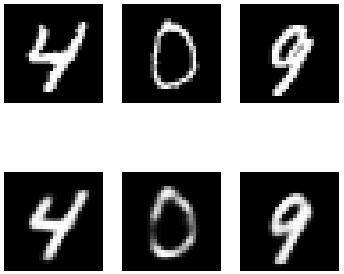

In [ ]:
# Test model reconstruction
# Reconstruct and visualize some test images
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)
        y_onehot = F.one_hot(y, num_classes=num_classes).float()
        x_recon, _, _ = model_conditional_vae(x, y_onehot)
        break  # Only process one batch for visualization

# Display original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_recon[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.show()

### Visualize CVAE sampling results (15 points)

In [ ]:
def generate_images_cvae(digit_to_generate):
    '''This function generates 10 sampled images from the given digit class.
    '''
    ####### TODO: sample 10 images from the model #######
    # Sample from Gaussian noise with class label
    num_samples = 10
    pass

    # Create one-hot encoded class label
    pass

    # Generate images from the noise and class label
    pass

    # The output images must be in the 'generated_images' variable.
    # generated_images = ...
    ##### END TODO sample 10 images from the model #######

    # Visualize the generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')
    plt.title(f"Generated Images of Digit {digit_to_generate}")
    plt.show()

Minimum expected quality looks similar to this example. You will receive no points if none of the generated images for a given digit is recognisable (the whole digit class fails).

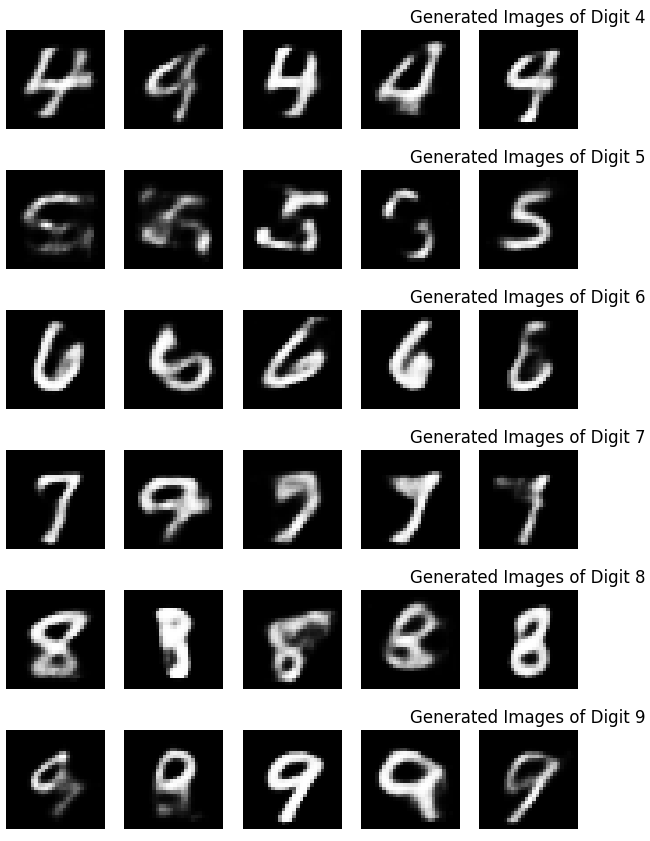

In [ ]:
# Visualize 10 sampled images for each digit class.
for i in range(10):
  generate_images_cvae(i)